In [13]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import tensorflow_addons as tfa
import os
from PIL import Image
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

import ecoset
import categorization as cat
import utils

# Setup Ecoset models

In [5]:
# Load model
ecosetModel = ecoset.make_alex_net_v2(
    weights_path='./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89',
)
imagenetModel = ecoset.make_alex_net_v2(
    output_shape=1000, 
    weights_path='./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89',
)
ecosetModel.summary()

2023-01-07 16:08:00.452890: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-07 16:08:00.493967: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-01-07 16:08:00.494016: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: andrexia3
2023-01-07 16:08:00.494026: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: andrexia3
2023-01-07 16:08:00.494798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-07 16:08:00.494837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2023-01-07 16:08:00.494847: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.141.3 does not match DSO version 470.161.3 --

Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
Weights from ./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 54, 54, 64)        23296     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 26, 26, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 26, 26, 192)       307392    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 192)       0         
_______________________

In [6]:
ecosetModel = utils.make_output_model(ecosetModel)
imagenetModel = utils.make_output_model(imagenetModel)

In [7]:
# model = ecoset.make_vNet(
#     weights_path='./models/vNET/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch79',
#     softmax=True,)
# model = Imagenet.make_vNet(
#     output_shape=1000, 
#     weights_path='./models/vNET/ILSVRC_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch79',
#     softmax=True,
# )
# model.summary()

# Setup Categorization Stimuli

In [8]:
trainCats, trainCounts = cat.build_categories_from_ecoset(
    './images/train', 
    includeSub=False,
    maxImgs=100
    )
testCats, testCounts = cat.build_categories_from_ecoset(
    './images/val+test',
    includeSub=False,
    maxImgs=100
)

trainImages = cat.get_images_from_cat(trainCats, preprocFun=ecoset.preprocess_alexnet)
testImages = cat.get_images_from_cat(testCats, preprocFun=ecoset.preprocess_alexnet)

In [9]:
birdTrainReps = ecosetModel.predict(trainImages['animal']['0085_bird'])[-1]
dogTrainReps = ecosetModel.predict(trainImages['animal']['0039_dog'])[-1]
carTrainReps = ecosetModel.predict(trainImages['vehicle']['0009_car'])[-1]
busTrainReps = ecosetModel.predict(trainImages['vehicle']['0089_bus'])[-1]

animalTrainReps = np.concatenate((birdTrainReps, dogTrainReps))
vehicleTrainReps = np.concatenate((carTrainReps, busTrainReps))

birdTestReps = ecosetModel.predict(testImages['animal']['0085_bird'])[-1]
dogTestReps = ecosetModel.predict(testImages['animal']['0039_dog'])[-1]
carTestReps = ecosetModel.predict(testImages['vehicle']['0009_car'])[-1]
busTestReps = ecosetModel.predict(testImages['vehicle']['0089_bus'])[-1]

animalTestReps = np.concatenate((birdTestReps, dogTestReps))
vehicleTestReps = np.concatenate((carTestReps, busTestReps))

2023-01-07 16:08:17.988791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-07 16:08:18.012643: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3500005000 Hz


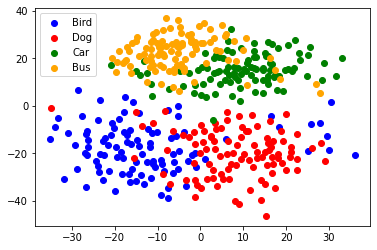

In [11]:
embedding = MDS(n_components=2)
solution = embedding.fit_transform(np.concatenate((birdTrainReps, dogTrainReps, carTrainReps, busTrainReps)))
plt.scatter(solution[0:100, 0], solution[0:100, 1], c='blue')
plt.scatter(solution[100:200, 0], solution[100:200, 1], c='red')
plt.scatter(solution[200:300, 0], solution[200:300, 1], c='green')
plt.scatter(solution[300:400, 0], solution[300:400, 1], c='orange')
plt.legend(['Bird', 'Dog', 'Car', 'Bus'])

# Category Verification Ecoset Model + GCM

In [14]:
# Reimplementation of task to confirmation task
maxExem = birdTrainReps.shape[0]
criterion = 25

verifData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])
for rep in birdTestReps:
    evidence = cat.get_evidence(rep, birdTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    evidence = cat.get_evidence(rep, dogTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    evidence = cat.get_evidence(rep, carTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    evidence = cat.get_evidence(rep, busTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in animalTestReps:
    evidence = cat.get_evidence(rep, animalTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in vehicleTestReps:
    evidence = cat.get_evidence(rep, vehicleTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [57]:
# Group data basic on level and count responses
accData = verifData.groupby(['level'])['resp'].value_counts()
# Remove no responses from accuracy
accData = accData.drop('no', level=1)
# Convert accuracy to percentage
accData = accData / 400 * 100
accData

level  resp
basic  yes     94.75
super  yes     89.00
Name: resp, dtype: float64

In [53]:
rtData = verifData.groupby(['level'])['rt'].mean()
# Convert to ms
rtData = rtData * 1000

# Calculate SD for RT
rtDataSD = verifData.groupby(['level'])['rt'].std()
# Convert to ms
rtDataSD = rtDataSD * 1000

rtData

level
basic    869.541446
super    894.897101
Name: rt, dtype: float64

In [31]:
accData.index

MultiIndex([('basic', 'yes'),
            ('super', 'yes')],
           names=['level', 'resp'])

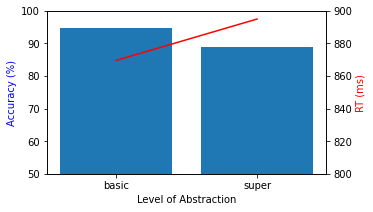

In [58]:
# Bar chart of accuracy by level
fig, ax1 = plt.subplots(figsize=(5, 3))
ax2 = ax1.twinx()
ax1.bar(['basic', 'super'], accData)
ax1.set_xlabel('Level of Abstraction')
ax1.set_ylabel('Accuracy (%)', color='blue')
ax1.set_ylim([50, 100])
ax2.plot(['basic', 'super'], rtData, color='red')
#ax2.errorbar(['basic', 'super'], rtData, yerr=rtDataSD, color='red')
ax2.set_ylabel('RT (ms)', color='red')
ax2.set_ylim([800, 900])

fig.show()


# Category Verification VGG16 Model + GCM Similarity

In [10]:
model = tf.keras.applications.vgg16.VGG16(include_top=True)

# Get output from penultimate layer
model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

2022-08-19 11:04:45.966233: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


In [11]:
trainCats, trainCounts = cat.build_categories_from_ecoset(
    './images/train', 
    includeSub=False,
    maxImgs=100
    )
testCats, testCounts = cat.build_categories_from_ecoset(
    './images/val+test',
    includeSub=False,
    maxImgs=100
)

def vggPreprocess(img):
    if isinstance(img, Image.Image):
        img = img.convert("RGB")
    img = np.array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img
    
trainVGGImages = cat.get_images_from_cat(trainCats, preprocFun = vggPreprocess)
testVGGImages = cat.get_images_from_cat(testCats, preprocFun = vggPreprocess)

In [12]:
birdTrainVGGReps = model.predict(trainVGGImages['animal']['0085_bird'])
dogTrainVGGReps = model.predict(trainVGGImages['animal']['0039_dog'])
carTrainVGGReps = model.predict(trainVGGImages['vehicle']['0009_car'])
busTrainVGGReps = model.predict(trainVGGImages['vehicle']['0089_bus'])

animalTrainVGGReps = np.concatenate((birdTrainVGGReps, dogTrainVGGReps))
vehicleTrainVGGReps = np.concatenate((carTrainVGGReps, busTrainVGGReps))

birdTestVGGReps = model.predict(testVGGImages['animal']['0085_bird'])
dogTestVGGReps = model.predict(testVGGImages['animal']['0039_dog'])
carTestVGGReps = model.predict(testVGGImages['vehicle']['0009_car'])
busTestVGGReps = model.predict(testVGGImages['vehicle']['0089_bus'])

animalTestVGGReps = np.concatenate((birdTestVGGReps, dogTestVGGReps))
vehicleTestVGGReps = np.concatenate((carTestVGGReps, busTestVGGReps))

2022-08-19 11:04:51.839231: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-08-19 11:04:51.863648: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-08-19 11:04:52.015468: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-08-19 11:04:52.015542: W tensorflow/core/common_runtime/bfc_allocator.cc:271] All

In [13]:
# Reimplementation of task to confirmation task
maxExem = birdTrainVGGReps.shape[0]
criterion = 25

verifVGGData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])
for rep in birdTestVGGReps:
    evidence = cat.get_evidence(rep, birdTrainVGGReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifVGGData = verifVGGData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestVGGReps:
    evidence = cat.get_evidence(rep, dogTrainVGGReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifVGGData = verifVGGData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestVGGReps:
    evidence = cat.get_evidence(rep, carTrainVGGReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifVGGData = verifVGGData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestVGGReps:
    evidence = cat.get_evidence(rep, busTrainVGGReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifVGGData = verifVGGData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in animalTestVGGReps:
    evidence = cat.get_evidence(rep, animalTrainVGGReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifVGGData = verifVGGData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in vehicleTestVGGReps:
    evidence = cat.get_evidence(rep, vehicleTrainVGGReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.5)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifVGGData = verifVGGData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [14]:
# Group data basic on level and count responses
verifVGGData.groupby(['level'])['resp'].value_counts()

level  resp
basic  no      212
       yes     188
super  no      249
       yes     151
Name: resp, dtype: int64

In [15]:
verifVGGData.groupby(['level'])['rt'].mean()

level
basic    0.893288
super    0.895871
Name: rt, dtype: float64

# Category Choice Ecoset Model + GCM Sim

In [7]:
# Perform cat comparing against only the most similar category
withinCatEcosetData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, dogTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, birdTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, busTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, carTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetData = withinCatEcosetData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [8]:
# Group data basic on level and count responses
withinCatEcosetData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     369
       no       31
super  yes     396
       no        4
Name: resp, dtype: int64

In [9]:
# Group data basic on level and get mean RTs
withinCatEcosetData.groupby(['level'])['rt'].mean()

level
basic    1.828109
super    1.549011
Name: rt, dtype: float64

In [11]:
# Perform cat comparing against all other categories
betweenCatEcosetData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, [dogTrainReps, carTrainReps, busTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, [birdTrainReps, carTrainReps, busTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, [busTrainReps, dogTrainReps, birdTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, [carTrainReps, dogTrainReps, birdTrainReps], cat.gcm_sim, equalize=True)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    betweenCatEcosetData = betweenCatEcosetData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [12]:
# Group data basic on level and count responses
betweenCatEcosetData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     398
       no        2
super  yes     396
       no        4
Name: resp, dtype: int64

In [13]:
# Group data basic on level and get mean RTs
betweenCatEcosetData.groupby(['level'])['rt'].mean()

level
basic    1.360280
super    1.218595
Name: rt, dtype: float64

# Category Choice Ecoset Model + Redist Sim

In [54]:
# Perform cat comparing against all other categories
withinCatEcosetRedistData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])
simFun = lambda x, y: cat.gcm_sim(x, y, p=1)

for rep in birdTestReps:
    birdEvidence = cat.redist_evidence(rep, birdTrainReps, dogTrainReps, simFun, dist_penalty=False)
    dogEvidence = cat.redist_evidence(rep, dogTrainReps, birdTrainReps, simFun, dist_penalty=False)
    birdProb = birdEvidence / (birdEvidence + dogEvidence)
    dogProb = dogEvidence / (birdEvidence + dogEvidence)
    resp, rt = cat.LBA_deterministic(birdProb, dogProb)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    birdEvidence = cat.redist_evidence(rep, birdTrainReps, dogTrainReps, simFun, dist_penalty=False)
    dogEvidence = cat.redist_evidence(rep, dogTrainReps, birdTrainReps, simFun, dist_penalty=False)
    birdProb = birdEvidence / (birdEvidence + dogEvidence)
    dogProb = dogEvidence / (birdEvidence + dogEvidence)

    resp, rt = cat.LBA_deterministic(dogProb, birdProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    carEvidence = cat.redist_evidence(rep, carTrainReps, busTrainReps, simFun, dist_penalty=False)
    busEvidence = cat.redist_evidence(rep, busTrainReps, carTrainReps, simFun, dist_penalty=False)
    carProb = carEvidence / (carEvidence + busEvidence)
    busProb = busEvidence / (carEvidence + busEvidence)

    resp, rt = cat.LBA_deterministic(carProb, busProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    carEvidence = cat.redist_evidence(rep, carTrainReps, busTrainReps, simFun, dist_penalty=False)
    busEvidence = cat.redist_evidence(rep, busTrainReps, carTrainReps, simFun, dist_penalty=False)
    carProb = carEvidence / (carEvidence + busEvidence)
    busProb = busEvidence / (carEvidence + busEvidence)

    resp, rt = cat.LBA_deterministic(busProb, carProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    animalEvidence = cat.redist_evidence(rep, animalTrainReps, vehicleTrainReps, simFun, dist_penalty=False)
    vehicleEvidence = cat.redist_evidence(rep, vehicleTrainReps, animalTrainReps, simFun, dist_penalty=False)
    animalProb = animalEvidence / (animalEvidence + vehicleEvidence)
    vehicleProb = vehicleEvidence / (animalEvidence + vehicleEvidence)

    resp, rt = cat.LBA_deterministic(animalProb, vehicleProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    animalEvidence = cat.redist_evidence(rep, animalTrainReps, vehicleTrainReps, simFun, dist_penalty=False)
    vehicleEvidence = cat.redist_evidence(rep, vehicleTrainReps, animalTrainReps, simFun, dist_penalty=False)
    animalProb = animalEvidence / (animalEvidence + vehicleEvidence)
    vehicleProb = vehicleEvidence / (animalEvidence + vehicleEvidence)

    resp, rt = cat.LBA_deterministic(vehicleProb, animalProb)
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetRedistData = withinCatEcosetRedistData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [55]:
# Group data basic on level and count responses
withinCatEcosetRedistData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     375
       no       25
super  yes     392
       no        8
Name: resp, dtype: int64

In [56]:
# Group data basic on level and get mean RTs
withinCatEcosetRedistData.groupby(['level'])['rt'].mean()

level
basic    1.908248
super    1.848217
Name: rt, dtype: float64

# Category Choice Ecoset Model + Prod Sim

In [14]:
# Perform cat comparing against only the most similar category
withinCatEcosetProdData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, dogTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, birdTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, busTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, carTrainReps, cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.prod_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatEcosetProdData = withinCatEcosetProdData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [15]:
# Group data basic on level and count responses
withinCatEcosetProdData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     361
       no       39
super  yes     390
       no       10
Name: resp, dtype: int64

In [16]:
# Group data basic on level and get mean RTs
withinCatEcosetProdData.groupby(['level'])['rt'].mean()

level
basic    1.858523
super    1.585520
Name: rt, dtype: float64

# Category Choice VGG16 Model + GCM Sim

In [2]:
model = tf.keras.applications.vgg16.VGG16(include_top=True)

# Get output from penultimate layer
model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

model.summary()

2022-07-05 21:04:02.931333: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-05 21:04:02.964976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 21:04:02.965526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 208.91GiB/s
2022-07-05 21:04:02.965543: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-05 21:04:02.968642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-05 21:04:02.968685: I tensorflow/stream_executor/plat

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2022-07-05 21:04:04.472638: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


In [26]:
trainCats, trainCounts = cat.build_categories_from_ecoset(
    './images/train', 
    includeSub=False,
    maxImgs=100
    )
testCats, testCounts = cat.build_categories_from_ecoset(
    './images/val+test',
    includeSub=False,
    maxImgs=100
)

def vggPreprocess(img):
    if isinstance(img, Image.Image):
        img = img.convert("RGB")
    img = np.array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img
    
trainImages = cat.get_images_from_cat(trainCats, preprocFun = vggPreprocess)
testImages = cat.get_images_from_cat(testCats, preprocFun = vggPreprocess)

In [32]:
birdTrainReps = model.predict(trainImages['animal']['0085_bird'])
dogTrainReps = model.predict(trainImages['animal']['0039_dog'])
carTrainReps = model.predict(trainImages['vehicle']['0009_car'])
busTrainReps = model.predict(trainImages['vehicle']['0089_bus'])

birdTestReps = model.predict(testImages['animal']['0085_bird'])
dogTestReps = model.predict(testImages['animal']['0039_dog'])
carTestReps = model.predict(testImages['vehicle']['0009_car'])
busTestReps = model.predict(testImages['vehicle']['0089_bus'])

In [36]:
# Perform cat comparing against only the most similar category
withinCatVGGData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])

for rep in birdTestReps:
    probs = cat.sim_prob(rep, birdTrainReps, dogTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    probs = cat.sim_prob(rep, dogTrainReps, birdTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    probs = cat.sim_prob(rep, carTrainReps, busTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    probs = cat.sim_prob(rep, busTrainReps, carTrainReps, cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((birdTestReps, dogTestReps)):
    probs = cat.sim_prob(rep, [birdTrainReps, dogTrainReps], [carTrainReps, busTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in np.concatenate((carTrainReps, busTrainReps)):
    probs = cat.sim_prob(rep, [carTrainReps, busTrainReps], [birdTrainReps, dogTrainReps], cat.gcm_sim)
    resp, rt = cat.LBA_deterministic(probs[0], probs[1])
    resp = 'yes' if resp == 1 else 'no'

    # Add row
    withinCatVGGData = withinCatVGGData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

In [37]:
# Group data basic on level and count responses
withinCatVGGData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     381
       no       19
super  yes     267
       no      133
Name: resp, dtype: int64

In [38]:
withinCatVGGData.groupby(['level'])['rt'].mean()

level
basic    1.602942
super    1.588251
Name: rt, dtype: float64

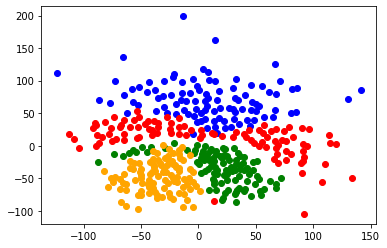

In [39]:
embedding = MDS(n_components=2)
solution = embedding.fit_transform(np.concatenate((birdTestReps, dogTestReps, carTestReps, busTestReps)))
plt.scatter(solution[0:100, 0], solution[0:100, 1], c='blue')
plt.scatter(solution[100:200, 0], solution[100:200, 1], c='red')
plt.scatter(solution[200:300, 0], solution[200:300, 1], c='green')
plt.scatter(solution[300:400, 0], solution[300:400, 1], c='orange')

# Sandbox

In [7]:
# Reimplementation of task to confirmation task
maxExem = birdTrainReps.shape[0]
criterion = 25

verifData = pd.DataFrame(columns=['level', 'cat', 'resp', 'rt'])
for rep in birdTestReps:
    evidence = cat.get_evidence(rep, birdTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bird',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in dogTestReps:
    evidence = cat.get_evidence(rep, dogTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'dog',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in carTestReps:
    evidence = cat.get_evidence(rep, carTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'car',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in busTestReps:
    evidence = cat.get_evidence(rep, busTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'basic',
        'cat': 'bus',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in animalTestReps:
    evidence = cat.get_evidence(rep, animalTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'animal',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)

for rep in vehicleTestReps:
    evidence = cat.get_evidence(rep, vehicleTrainReps, cat.gcm_sim, maxExem)
    drift = evidence / (evidence + criterion)
    resp, rt = cat.LBA_deterministic(drift, 1 - drift, b=.3)
    resp = 'yes' if resp == 1 else 'no'
    
    # Add row
    verifData = verifData.append({
        'level': 'super',
        'cat': 'vehicle',
        'resp': resp,
        'rt': rt
    }, ignore_index=True)


In [8]:
# Group data basic on level and count responses
verifData.groupby(['level'])['resp'].value_counts()

level  resp
basic  yes     379
       no       21
super  yes     354
       no       46
Name: resp, dtype: int64

In [9]:
verifData.groupby(['level'])['rt'].mean()

level
basic    0.521725
super    0.537252
Name: rt, dtype: float64